In [2]:
!pip install yfinance
!pip install backtesting


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import matplotlib.pyplot as plt

c:\Users\adars\anaconda3\envs\tf\lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [4]:
def EMA(series , period):
    series = pd.Series(series)
    return series.ewm(span=period).mean().values

In [5]:
def MACD(close, fast=25, slow=50, signal=12):
    close = pd.Series(close)
    macd = EMA(close, fast) - EMA(close, slow)
    signal_line = pd.Series(macd).ewm(span=signal, adjust=False).mean().values
    return np.array(macd), np.array(signal_line)


In [6]:
def ADX(high, low, close, period=14):
    high = pd.Series(high)
    low = pd.Series(low)
    close = pd.Series(close)
    
    df = pd.DataFrame({'High': high, 'Low': low, 'Close': close})
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        abs(df['High'] - df['Close'].shift()),
        abs(df['Low'] - df['Close'].shift())
    ])
    df['+DM'] = np.where((df['High'] - df['High'].shift()) > (df['Low'].shift() - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(), 0), 0)
    df['-DM'] = np.where((df['Low'].shift() - df['Low']) > (df['High'] - df['High'].shift()),
                         np.maximum(df['Low'].shift() - df['Low'], 0), 0)
    tr14 = df['TR'].rolling(window=period).sum()
    plus_dm14 = df['+DM'].rolling(window=period).sum()
    minus_dm14 = df['-DM'].rolling(window=period).sum()
    plus_di = 100 * (plus_dm14 / tr14)
    minus_di = 100 * (minus_dm14 / tr14)
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.rolling(window=period).mean()
    return adx.values

In [7]:
class ImprovedStrategy(Strategy):
    def init(self):
        close = self.data.Close
        self.ema_short = self.I(EMA, close, 25)
        self.ema_long = self.I(EMA, close, 50)
        self.macd, self.macd_signal = self.I(MACD, close)
        self.adx = self.I(ADX, self.data.High, self.data.Low, close)
        self.min_period = 50
        
    def next(self):
        macd_cross = crossover(self.macd, self.macd_signal)
        strong_trend = self.adx[-1] > 15  # Lower threshold to allow more trades
        close_to_ema = (abs(self.data.Close[-1] - self.ema_long[-1])/self.ema_long[-1] < 0.04)  # Allow 5% deviation
        
        # Now require MACD crossover and at least one favorable condition
        if macd_cross and (strong_trend or close_to_ema):
            if not self.position:
                self.buy(
                    sl=0.95 * self.data.Close[-1],
                    tp=1.0489 * self.data.Close[-1] )

In [8]:
def prepare_data(ticker):
    df = yf.download(ticker, start="2021-01-01", end="2024-12-31")
    
    # Ensure we have the required columns
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1) if df.columns.nlevels > 1 else df.columns
        
    # Select only the columns we need
    df = df[required_cols].copy()
    
    # Drop any rows with NaN values
    df = df.dropna()
    
    return df

In [9]:
data = prepare_data("MRF.NS")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [10]:
print("Columns:", data.columns)
print("Index type:", type(data.index))
print("Sample data:")
print(data.head())

Columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Sample data:
Price               Open          High           Low         Close  Volume
Date                                                                      
2021-01-01  75563.444664  75895.875662  75116.029531  75584.968750   13254
2021-01-04  75762.927680  78446.773309  75464.006263  77951.835938   28145
2021-01-05  77353.103693  78917.068116  77253.678110  78598.906250   25539
2021-01-06  78598.889565  79341.598514  77173.328964  78299.867188   30427
2021-01-07  79043.323113  79043.323113  76557.684022  76888.375000   21765


In [11]:
def calculate_profit_metrics(trades):
   
        # Filter out trades with zero PnL (if any)
        trades = trades[trades['PnL'] != 0]
        
        # Calculate winning and losing trades
        winning_trades = trades[trades['PnL'] > 0]
        losing_trades = trades[trades['PnL'] < 0]
        
        # Calculate basic metrics
        total_profit = winning_trades['PnL'].sum()
        total_loss = abs(losing_trades['PnL'].sum())
        profit_factor = total_profit / total_loss if total_loss != 0 else np.inf
        
        # Calculate average profit/loss
        avg_profit = winning_trades['PnL'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['PnL'].mean() if len(losing_trades) > 0 else 0
        
        # Calculate max profit/loss
        max_profit = winning_trades['PnL'].max() if len(winning_trades) > 0 else 0
        max_loss = losing_trades['PnL'].min() if len(losing_trades) > 0 else 0
        
        # Calculate win rate
        win_rate = len(winning_trades) / len(trades) if len(trades) > 0 else 0
        
        # Calculate profit/loss ratio
        profit_loss_ratio = abs(avg_profit / avg_loss) if avg_loss != 0 else np.inf
        
        # Prepare metrics dictionary
        metrics = {
            'Profit Factor': profit_factor,
            'Average Profit': avg_profit,
            'Average Loss': avg_loss,
            'Maximum Profit': max_profit,
            'Maximum Loss': max_loss,
        }
        return metrics


C:\Users\adars\AppData\Local\Temp\ipykernel_17604\817762316.py:1: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, ImprovedStrategy, cash=100000, commission=0.0001)
c:\Users\adars\anaconda3\envs\tf\lib\site-packages\backtesting\backtesting.py:954: UserWarning: time=772: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\adars\anaconda3\envs\tf\lib\site-packages\backtesting\backtesting.py:954: UserWarning: time=835: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\adars\anaconda3\envs\tf\lib\site-packages\backtesting\backtesting.py:954: UserWarning: time=897: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\adars\anaconda3\envs\tf\lib\site-packages\backtesting\backtesting.py:954

Start                     2021-01-01 00:00:00
End                       2024-12-30 00:00:00
Duration                   1459 days 00:00:00
Exposure Time [%]                    23.32657
Equity Final [$]                 139077.49554
Equity Peak [$]                  139077.49554
Commissions [$]                     298.58218
Return [%]                            39.0775
Buy & Hold Return [%]                36.01172
Return (Ann.) [%]                      8.7961
Volatility (Ann.) [%]                 7.65892
CAGR [%]                              5.86282
Sharpe Ratio                          1.14848
Sortino Ratio                         2.17764
Calmar Ratio                          1.05449
Alpha [%]                             35.1124
Beta                                  0.11011
Max. Drawdown [%]                     -8.3416
Avg. Drawdown [%]                    -2.44205
Max. Drawdown Duration      206 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                          

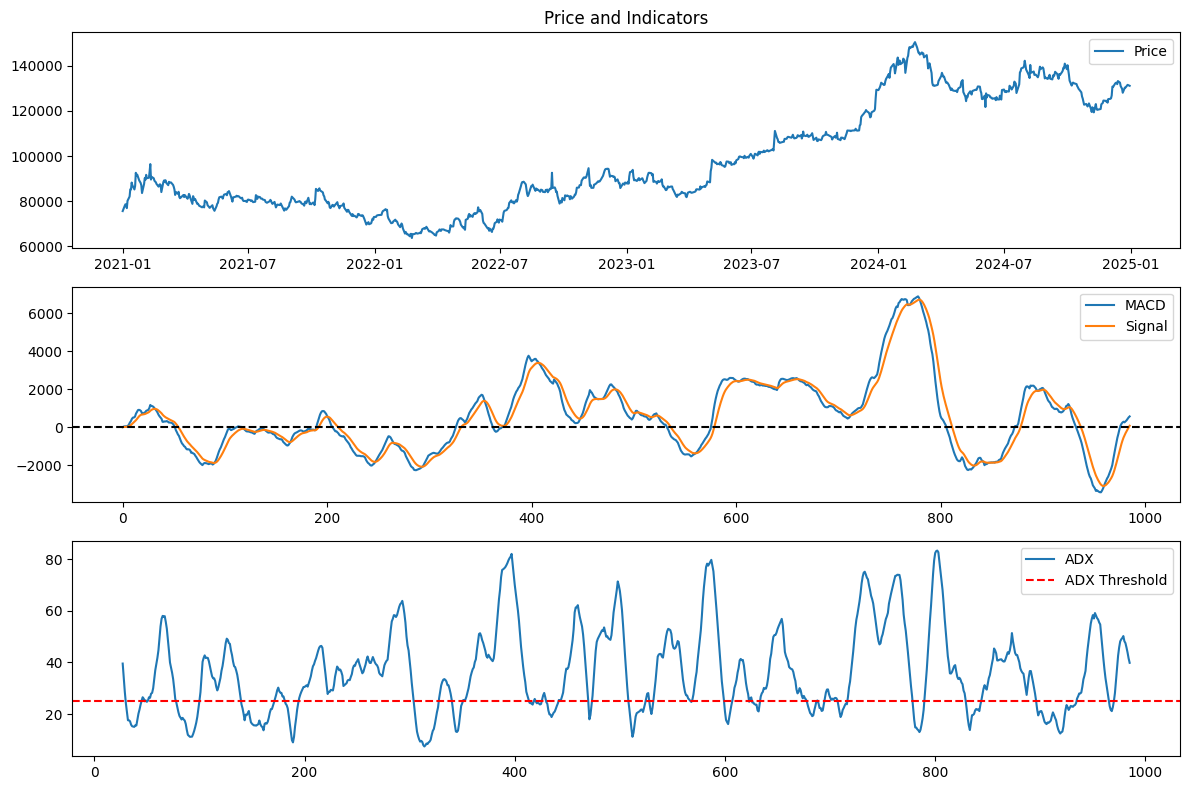

In [12]:
bt = Backtest(data, ImprovedStrategy, cash=100000, commission=0.0001)
results = bt.run()
print(results)
trades_df = results._trades
profit_metrics = calculate_profit_metrics(trades_df)
print(pd.Series(profit_metrics))

# Add this after your backtest
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.title('Price and Indicators')
plt.plot(data['Close'], label='Price')
plt.legend()

plt.subplot(312)
plt.plot(results._strategy.macd, label='MACD')
plt.plot(results._strategy.macd_signal, label='Signal')
plt.axhline(0, color='black', linestyle='--')
plt.legend()

plt.subplot(313)
plt.plot(results._strategy.adx, label='ADX')
plt.axhline(25, color='red', linestyle='--', label='ADX Threshold')
plt.legend()
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


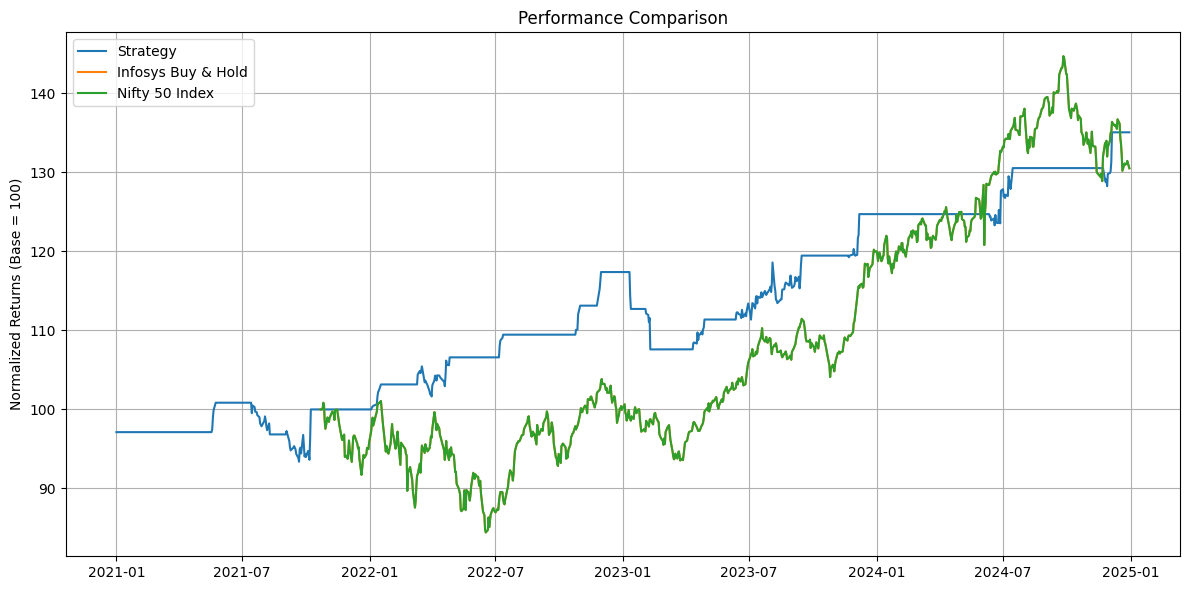

In [13]:
data = prepare_data("^NSEI")  # Nifty 50 index.

# Tag regimes on Nifty data
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['Regime'] = np.where(
    data['SMA_50'] > data['SMA_200'], 'Bull',
    np.where(data['SMA_50'] < data['SMA_200'], 'Bear', 'Sideways')
)

# Merge regime info with Infosys data
data = data.copy()
data['Regime'] = data['Regime']
data.dropna(inplace=True)


# --- Calculate and Plot Returns ---
def calculate_normalized_returns(price_series, base_date=None):
    if base_date is None:
        base_date = price_series.index[0]
    return price_series / price_series.loc[base_date] * 100

# Find common base date
base_date = max(data.index[0], data.index[0])

# Calculate normalized returns
strategy_returns = calculate_normalized_returns(results._equity_curve['Equity'], base_date)
infosys_returns = calculate_normalized_returns(data['Close'], base_date)
nifty_returns = calculate_normalized_returns(data['Close'], base_date)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(strategy_returns.index, strategy_returns, label='Strategy')
plt.plot(infosys_returns.index, infosys_returns, label='Infosys Buy & Hold')
plt.plot(nifty_returns.index, nifty_returns, label='Nifty 50 Index')

plt.title("Performance Comparison")
plt.ylabel("Normalized Returns (Base = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# --- Performance Metrics ---
def calculate_cumulative_return(series):
    return (series.iloc[-1] - series.iloc[0]) / series.iloc[0]

print("\n--- Cumulative Returns ---")
print(f"Strategy: {calculate_cumulative_return(results._equity_curve['Equity']) * 100:.2f}%")
print(f"Infosys Buy & Hold: {calculate_cumulative_return(data['Close']) * 100:.2f}%")
df_nifty = prepare_data("^NSEI")  # Prepare data for Nifty 50 index
print(f"Nifty 50 Index: {calculate_cumulative_return(df_nifty['Close']) * 100:.2f}%")

print("\n--- Strategy Performance ---")
print(f"Sharpe Ratio: {results['Sharpe Ratio']:.2f}")
print(f"Sortino Ratio: {results['Sortino Ratio']:.2f}")
print(f"Max Drawdown: {results['Max. Drawdown [%]']:.2f}%")
print(f"Win Rate: {results['Win Rate [%]']:.2f}%")

print("\n--- Annualized Return ---")
print(f"CAGR: {results['CAGR [%]']:.2f}%")

print("\n--- Profit Factor Metrics ---")
# Display as a formatted Series
metrics_series = pd.Series(profit_metrics)
print(metrics_series.to_string(float_format="{:,.2f}".format))

[*********************100%***********************]  1 of 1 completed


--- Cumulative Returns ---
Strategy: 39.08%
Infosys Buy & Hold: 30.53%
Nifty 50 Index: 68.67%

--- Strategy Performance ---
Sharpe Ratio: 1.15
Sortino Ratio: 2.18
Max Drawdown: -8.34%
Win Rate: 81.25%

--- Annualized Return ---
CAGR: 5.86%

--- Profit Factor Metrics ---
Profit Factor         3.78
Average Profit    4,118.33
Average Loss     -4,720.75
Maximum Profit    6,024.13
Maximum Loss     -5,255.71
